In [1]:
#importing the MNIST dataset to understand classification models
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version =1)
mnist.keys()

C:\Users\vishw\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


Each row contains intensity of an 28*28 = 784 pixels which can be used to depict images of handwritten digits form 0 to 9

In [3]:
y.value_counts() 

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64

In [4]:
y=y.astype('int')

The data can be interpreted as homogenous 

In [5]:
#let us split the dataset into train and test set before any further analysis. This dataset available at sklearn is already divided into stratified samples for training and testing with shuffling of index.
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[:60000]


In [6]:
#let's start by training a binary classifier on the dataset
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
#We will use a Stochastics gradient descent classifier since it is fast
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train, y_train_5)


SGDClassifier()

In [8]:
#let us measure the accuracy of this model using cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train_5, cv=5,scoring='accuracy' )

array([0.96716667, 0.97008333, 0.96591667, 0.95183333, 0.95808333])

Our model is providing a pretty much good accuray across all the 5 samples. But we will find out that accuracy does'nt depict the real performance of our classifier since there is huge class imbalance in target column y_train_5.

In [9]:
#let's create a function to calculate cross_validation score such that each sample taken is stratified, therefore representing the dataset in a better way.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def cross_validate_accuracy(model, cv, X,y):
    skf = StratifiedKFold(n_splits =cv)
    accuracy = []
    for train_index, test_index in skf.split(X,y):
        model = clone(model) #to create a clone of the model, forgetting every parameter it has learned except the hyperparameter specified.
        X_train_fold = X.iloc[train_index] #will return one training fold each time the loop is executed using the stratified train index
        y_train_fold =y.iloc[train_index]
        X_test_fold = X.iloc[test_index]
        y_test_fold = y.iloc[test_index]
        model.fit(X_train_fold, y_train_fold)
        predicted = model.predict(X_test_fold)
        acc = sum(y_test_fold == predicted)/len(y_test_fold)
        accuracy.append(acc)
    return accuracy

In [10]:
print(cross_validate_accuracy(sgd_classifier, 5, X_train, y_train_5))

[0.97175, 0.96325, 0.9600833333333333, 0.93825, 0.9624166666666667]


We can observe that the accuracy is great, but maybe we are not able to see the full picture here. We will use confusion matrix to observe the full picture of our classification problem.

In [11]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [12]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_train_5, y_train_pred)
cm

array([[54028,   551],
       [ 1486,  3935]], dtype=int64)

In [13]:
#let us assign these four numbers to their respective variables with a correct representation.
true_negative = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_positive = cm[1][1]
precision = true_positive/(true_positive+false_positive) #how many of predicted positives are actually positives
recall = true_positive/(true_positive+false_negative) #out of all actual positives how many was our predictor able to classify correct
#recall is also called sensitivity or true positive rate
#let us calculate precision and recall
print('precision',precision,'recall',recall)

precision 0.8771734284440481 recall 0.7258808337945029


In [14]:
#let us see how we can use sklearn to calculate these metrics
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_pred=y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8771734284440481
0.7258808337945029


We can observe that the scores calculated by sklearn are similar.

In [15]:
#it is often convenient to take the harmonic mean of precision score and recall score to get an average idea of overall performance of the model.
f1_score=((2*precision*recall)/(precision+recall))
print(f1_score)

0.7943878066013929


We need to understand that there is a tradeoff between precision and recall 
#### Increasing precision decreases recall
In the above case we got the final prediction but we can also get the scores if we use the `decision_function()` method of SGDClassifier. Now we will use the scores and manipulate the threshold to get an understanding of the tradeoff between precision and recall.

In [16]:
#the default threshold for SGDClassifier is zero
y_train_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')
import matplotlib.pyplot as plt
#Now with these scores we can compute precision, recall for all thresholds using the sklearn function
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_train_scores)

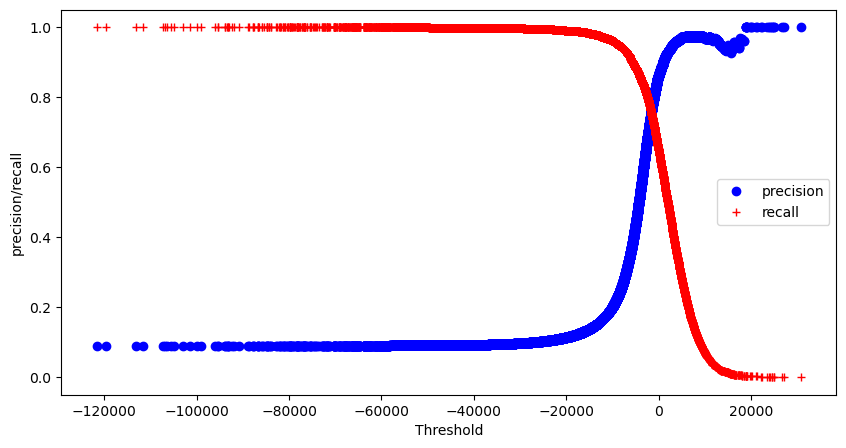

In [22]:
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions[:-1], 'bo', label='precision')
plt.plot(thresholds, recalls[:-1], 'r+', label = 'recall')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("precision/recall")
plt.show()

### Let's try to understand in more detail the tradeoff between Precision/Recall or Sensitivity and specificity

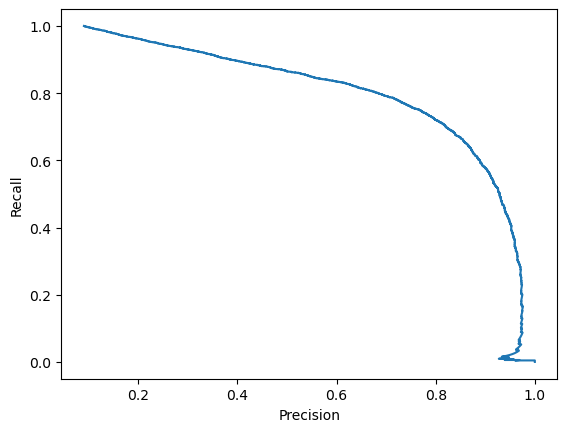

In [25]:
#Another way of evaluating the model is plotting precision against recall.
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

Let's see how we can use these curves to find a threshold which provides 90% precision with the maximum recall we can get at this presision

In [26]:
import numpy as np
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
#using this threshold to predict the classes.
y_train_pred_90 = (y_train_scores>= threshold_90_precision).astype('int')
#lets check the precision and recall score
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9001438848920863
0.5770153108282605


## The Reciever Operating Characteristic curve
It plots the True positive rate/recall against the false positive rate

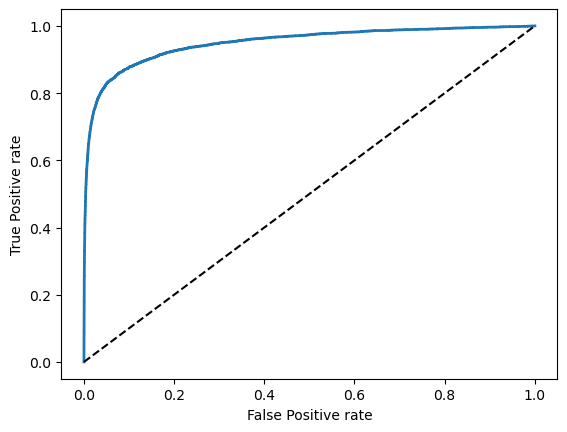

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_train_scores)
plt.plot(fpr, tpr, linewidth =2)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.show()


In [30]:
#One way to compare the classifiers is to measure the area under the curve(AUC).
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_train_scores))

0.9496355729051758


Looking at this ROC curve you may think that the classifier is really good. But this is mostly because there are few positives compared to the negatives . In contrast, the PR curve makes it clear that the classifier has room for improvement.

Let's try using a stronger classifier and compare it using the metrics we just studied

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rndm_clf = RandomForestClassifier(verbose =2)
rndm_clf.fit(X_train, y_train_5)
prob = rndm_clf.predict_proba(X_train)
prob[:5]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   24.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


array([[0.05, 0.95],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ]])

[]

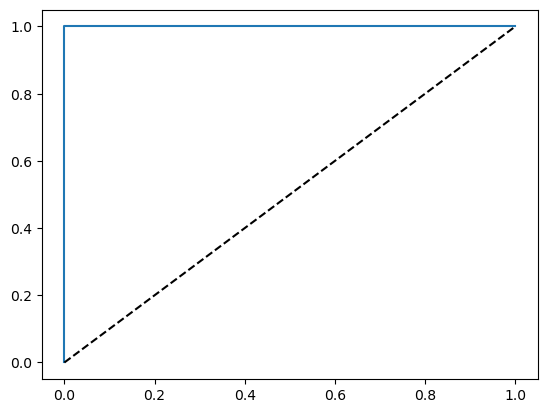

In [33]:
y_prob_positive = prob[:,1]
#let's plot the ROC curve for it
fpr, tpr, thresholds = roc_curve(y_train_5, y_prob_positive)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], 'k--')
plt.plot()

In [35]:
#let's find out the precision, recall, and accuracy for this model
y_rndm_train = (y_prob_positive>=0.5).astype('int')
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(y_train_5, y_rndm_train))
print('recall', recall_score(y_train_5, y_rndm_train))
print("precision", recall_score(y_train_5, y_rndm_train))
confusion_matrix(y_train_5,y_rndm_train)

accuracy 1.0
recall 1.0
precision 1.0


array([[54579,     0],
       [    0,  5421]], dtype=int64)

We can observe that we are recieving 100% of every metric with this classifier but these are not the signs of a great classifier it means that our model has probably overfit the data, that's why it is performing such good on the train data.

# Multiclass Classification
Multiclass classifiers can distinguish between more than two classes. Some algorithms such as RandomForest classifier or Naive Bayes classifier are capable of handling multiclass problems while others such as Suppost Vector Machines or other Linear classifiers can only handle binary classification but there are different ways of using multiple binary classifiers to perform multiclass classification. 
## OvA (One vs All) classifier
For example, you can to train a classifier to classify among classes 1 to 10. You can train 10 different binary classifiers for each digit, then at last you can use these classifiers to get the scores/probability from each of them and choose the digit with the highest probability/score. 
## OvO (One vs One) classifier
Train a binary classifier for every pair of digits. Therefore we need to train N*(N-1)/2 binary classifiers, suppose you want to predict a class, you will use all the classifiers for prediction and see which class wins the most duels. We will need to train a lot of classifiers but each classifier will only be trained on a subset of the dataset. For models such as SVM which scale poorly with the size of the dataset, OvO is a great strategy.

In [36]:
#let's use SGD classifier for multiclass classification, as soon as sklearn detects that we want to do multiclass classification it already implements the OvA stratedy except in SVM models.
sgd_classifier.fit(X_train, y_train)

SGDClassifier()

In [37]:
#let's get the predictions and scores of this classifier 
y_train_p = sgd_classifier.predict(X_train)
y_train_decision = sgd_classifier.decision_function(X_train)
y_train_decision[:5]


array([[-16880.56315365, -27193.70206738,  -9312.09379952,
          -808.81140512, -12150.19554718,   3609.62255457,
        -34592.75337024, -12814.08310786, -11299.15634216,
        -12503.44264696],
       [ 23912.82452938, -28809.38598366,  -9153.69978049,
         -8856.48031505, -10315.6938346 , -10549.48042015,
        -20067.35463425, -15609.30328773,  -5048.90759371,
        -10027.50220912],
       [-27074.56135622, -20496.84038473,  -5411.47803743,
          -920.2352211 ,   1372.96425002, -19399.18819237,
        -37760.70710446,  -9777.63988443, -14351.06748451,
         -9256.00351765],
       [-16333.39083921,   5043.00307819,  -1961.82032868,
         -1093.75170204,  -1632.36392524,  -8109.02237586,
        -21727.30074734,  -8938.96664532,  -2280.28676711,
         -5668.03030965],
       [-32278.98854076, -14588.70116855, -18823.77516174,
         -7086.75909013,  -1476.81476443, -10138.85208852,
        -35563.27480174,  -6266.18250246,  -6414.05424842,
          1

In [39]:
print('accuracy', accuracy_score(y_train, y_train_p))
confusion_matrix(y_train,y_train_p)

accuracy 0.8981


array([[5795,    0,   35,    2,   29,   18,   16,    0,   25,    3],
       [   2, 6478,  103,   32,   21,   15,    7,   24,   54,    6],
       [  45,   20, 5575,   44,  108,   12,   20,   47,   77,   10],
       [  41,    8,  370, 5339,   18,  137,   13,   48,  105,   52],
       [  14,   28,   41,   14, 5496,    9,    7,   10,   32,  191],
       [  90,   12,   92,  197,  174, 4533,   74,   20,  162,   67],
       [  58,   13,  256,   13,  174,   83, 5276,    1,   40,    4],
       [  37,   10,   90,   35,   97,    5,    3, 5772,   19,  197],
       [ 103,   80,  208,  381,  125,  159,   13,   33, 4672,   77],
       [  58,   19,   34,  123,  348,   39,    1,  288,   89, 4950]],
      dtype=int64)

In [40]:
#this is the score when we used the OvA stratedy. Let's try using the OvO strategy on SGD model.
from sklearn.multiclass import OneVsOneClassifier

In [60]:
sgd=SGDClassifier()
ovo_classifier = OneVsOneClassifier(sgd)

# Let's create a pipeline that scales the input and then use ovo_classifier on the scaled inputs
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

ovo_classifier.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier())

In [61]:
scores = ovo_classifier.decision_function(X_train)

In [63]:
len(ovo_classifier.estimators_)

45

In [64]:
pred = ovo_classifier.predict(X_train)
print('accuracy', accuracy_score(y_train, pred))
confusion_matrix(y_train,pred)

accuracy 0.94555


array([[5893,    0,    2,    5,    2,   16,    0,    1,    4,    0],
       [   1, 6675,   16,   22,    0,    1,    0,    4,   20,    3],
       [  37,   47, 5368,  178,   51,   25,   72,   68,  105,    7],
       [  17,   11,   30, 5574,    3,  350,    3,   17,  104,   22],
       [   4,   11,   10,    2, 5675,    2,   13,   30,    3,   92],
       [  32,   10,   12,   63,   11, 5040,   24,    9,  189,   31],
       [  27,    5,    9,    3,   54,   83, 5706,    3,   28,    0],
       [  10,    7,   13,   39,   24,    0,    0, 6082,   11,   79],
       [  37,   58,   59,  115,    9,  210,   11,    7, 5276,   69],
       [  13,   18,    2,   48,  144,   17,    0,  243,   20, 5444]],
      dtype=int64)

The one vs one classifier is producing better accuracy

# Error Analysis

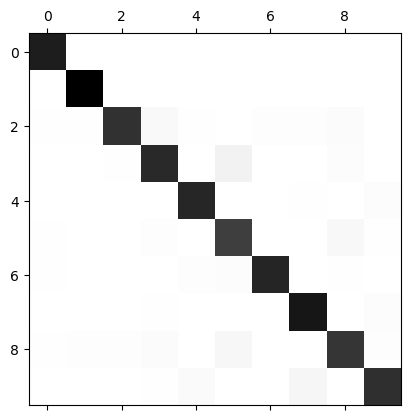

In [78]:
plt.matshow(confusion_matrix(y_train,pred), cmap=plt.cm.binary)
plt.show()

The 5s look slighty lighter than the other digits let's look more into the matter.
Let's focus the plot on the erros 

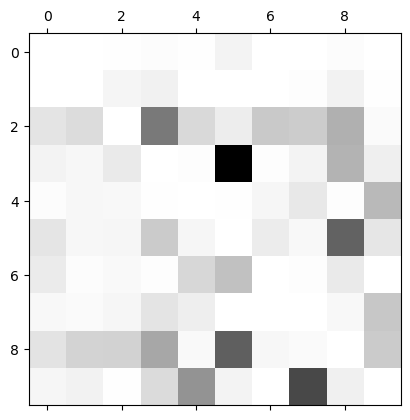

In [79]:
conf_mx = confusion_matrix(y_train, pred)
row_sums = conf_mx.sum(axis =1, keepdims =True)
norm_conf_mx = conf_mx/row_sums
#let's fill the diagonals with zero elements so that we can only focus on the errors.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap =plt.cm.binary)
plt.show()

We can observe the following things from the matrix:
- There is a high misclassification between 3/5, 8/5, 5/8, 7/9 , since these digits might look kind of similar to the algorithm 

# Multilabel Classification
Let us create a multilabel classifier which predicts whether a digit is greater than 5 and whether it is odd.

In [80]:
y_train_large = (y_train>=7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]


In [83]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
knc.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [93]:
print(knc.predict(X_train[:1]), y_train[0])

[[False  True]] 5


We can observe that it is making a correct prediction since 5 is not a large number therefore False and it is odd number therefore 5
### Let's try evaluating this model
we will compute the classification metrics for each label and then take the average to get the idea of its performance.

In [96]:
multi_pred = knc.predict(X_train)


In [97]:
pred_large = multi_pred[:,0]
pred_odd = multi_pred[:,1]
print(accuracy_score(y_train_large, pred_large), accuracy_score(y_train_odd, pred_odd), (accuracy_score(y_train_large, pred_large) +accuracy_score(y_train_odd, pred_odd))/2 )

0.9903333333333333 0.9896 0.9899666666666667


## Multioutput classification or Multioutput multiclass classification
It is a generalization of multilabel classification where each label can be multiclass. For example, let's train a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system


In [100]:
#let's add noise to the mnist images and the target will be the mnist images.
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mltopt = X_train + noise
test_noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mltopt = X_test + test_noise
y_train_mltopt = X_train
y_test_mltopt = X_test


In [101]:
knc.fit(X_train_mltopt, y_train_mltopt)

KNeighborsClassifier()

This classifier will do the provided task.